# Tutorial On Simple Reference Mapping

We compare Geneformer to UCE in this example.

In [1]:
import anndata as ad
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd
current_path = os.getcwd()
import warnings
warnings.filterwarnings("ignore")

## Dataset loading and Splitting

Before running this notebook, download the full dataset and config.json from this [link](https://drive.google.com/drive/folders/1HzI1kCnXzlrLQQxesVdPRDYDjJhbhQk-?usp=drive_link).

In [3]:
ann_data = ad.read_h5ad("./data/10k_pbmcs_proc.h5ad")
X_train, X_test = train_test_split(ann_data,train_size=0.01,test_size=0.005,random_state=0)

## Geneformer Model For Zero Shot Reference Mapping

In [4]:
from helical.models.geneformer.model import Geneformer,GeneformerConfig
model_config = GeneformerConfig(batch_size=5)   
geneformer = Geneformer(model_config=model_config)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-05-02, 20:28:07.721 Downloader INFO File: '/Users/maximeallard/.cache/helical/models/geneformer/gene_median_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
2024-05-02, 20:28:07.722 Downloader INFO File saved to: '/Users/maximeallard/.cache/helical/models/geneformer/gene_median_dictionary.pkl'
2024-05-02, 20:28:07.723 Downloader INFO File: '/Users/maximeallard/.cache/helical/models/geneformer/human_gene_to_ensemble_id.pkl' exists already. File is not overwritten and nothing is downloaded.
2024-05-02, 20:28:07.723 Downloader INFO File saved to: '/Users/maximeallard/.cache/helical/models/geneformer/human_gene_to_ensemble_id.pkl'
2024-05-02, 20:28:07.724 Downloader INFO File: '/Users/maximeallard/.cache/helical/models/geneformer/token_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
2024-05-02, 20:28:07.724 Downloader INF

In [5]:
train_dataset = geneformer.process_data(X_train, "./data/config.json")
test_dataset = geneformer.process_data(X_test, "./data/config.json")

Creating dataset.


Map (num_proc=4):   0%|          | 0/119 [00:00<?, ? examples/s]

Creating dataset.


Map (num_proc=4):   0%|          | 0/60 [00:00<?, ? examples/s]

In [6]:
ref_embeddings = geneformer.get_embeddings(train_dataset)
test_embeddings = geneformer.get_embeddings(test_dataset)

2024-05-02, 20:28:15.690 Geneformer-Model INFO Inference started


  0%|          | 0/24 [00:00<?, ?it/s]

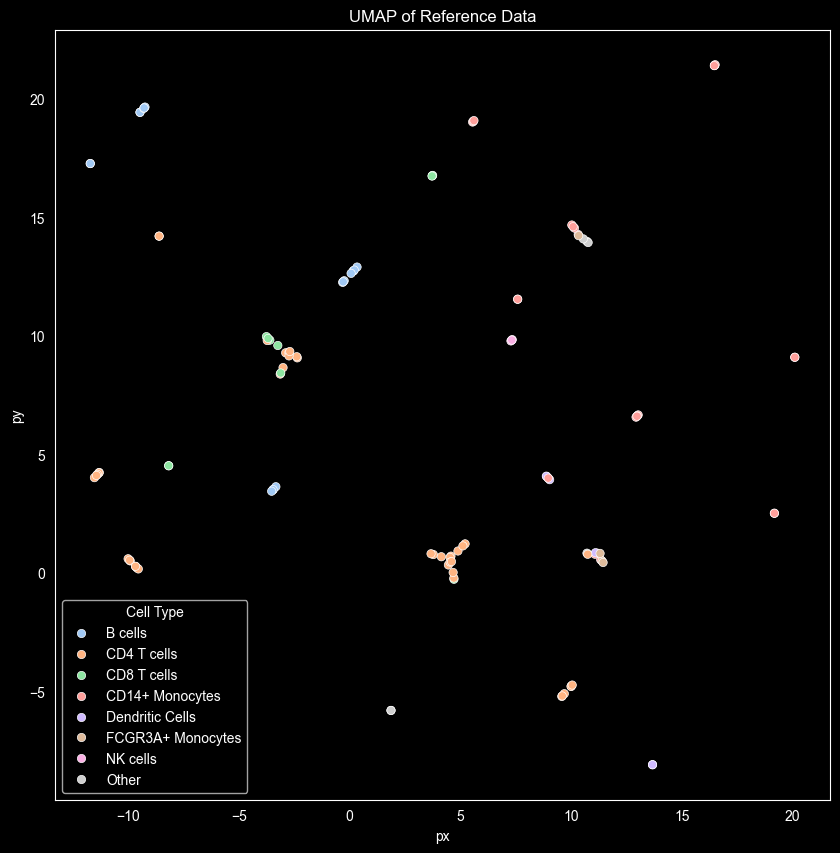

In [14]:
reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=2)
mapper = reducer.fit(ref_embeddings)

labels = X_train.obs['cell_type']

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")
plt.title('UMAP of Reference Data')
plt.show()

We use a K-Neirhbours classifier to find the cells which are the most similar to our test data.

In [10]:

labels = X_train.obs['cell_type']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

KNeighborsClassifier(metric='cosine')

In [11]:
pred_labels = neigh.predict(test_embeddings)

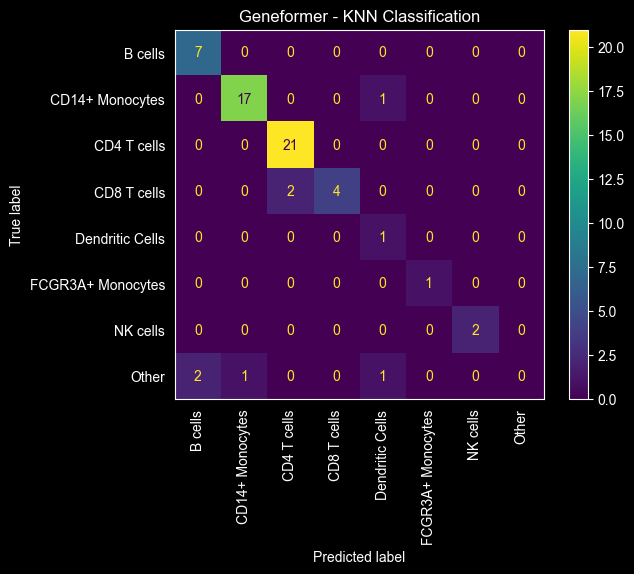

In [13]:

cm = confusion_matrix(X_test.obs['cell_type'],pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(xticks_rotation="vertical")
plt.title("Geneformer - KNN Classification")
plt.show()

In [15]:
print(classification_report(X_test.obs['cell_type'],pred_labels))

                   precision    recall  f1-score   support

          B cells       0.78      1.00      0.88         7
  CD14+ Monocytes       0.94      0.94      0.94        18
      CD4 T cells       0.91      1.00      0.95        21
      CD8 T cells       1.00      0.67      0.80         6
  Dendritic Cells       0.33      1.00      0.50         1
FCGR3A+ Monocytes       1.00      1.00      1.00         1
         NK cells       1.00      1.00      1.00         2
            Other       0.00      0.00      0.00         4

         accuracy                           0.88        60
        macro avg       0.75      0.83      0.76        60
     weighted avg       0.85      0.88      0.86        60



## UCE Model For Zero Shot Reference Mapping

In [3]:
from helical.models.uce.model import UCE,UCEConfig

model_config = UCEConfig(batch_size=5)
# uce = UCE(model_dir="./data/uce",model_config=model_config)
uce = UCE(model_config=model_config)

2024-05-02, 20:03:23.484 Downloader INFO Starting to download: 'https://helicalpublicdata.blob.core.windows.net/helicalpackage/data/uce/4layer_model.torch'


[==================================================]

2024-05-02, 20:10:38.241 Downloader INFO File saved to: '/Users/maximeallard/.cache/helical/models/uce/4layer_model.torch'
2024-05-02, 20:10:38.244 Downloader INFO Starting to download: 'https://helicalpublicdata.blob.core.windows.net/helicalpackage/data/uce/all_tokens.torch'


[==================================================]

2024-05-02, 20:19:17.708 Downloader INFO File saved to: '/Users/maximeallard/.cache/helical/models/uce/all_tokens.torch'
2024-05-02, 20:19:17.710 Downloader INFO Starting to download: 'https://helicalpublicdata.blob.core.windows.net/helicalpackage/data/uce/species_chrom.csv'


[==================================================]

2024-05-02, 20:19:19.551 Downloader INFO File saved to: '/Users/maximeallard/.cache/helical/models/uce/species_chrom.csv'
2024-05-02, 20:19:19.554 Downloader INFO Starting to download: 'https://helicalpublicdata.blob.core.windows.net/helicalpackage/data/uce/species_offsets.pkl'


[==================================================]

2024-05-02, 20:19:19.940 Downloader INFO File saved to: '/Users/maximeallard/.cache/helical/models/uce/species_offsets.pkl'
2024-05-02, 20:19:19.944 Downloader INFO File: '/Users/maximeallard/.cache/helical/models/uce/protein_embeddings/Homo_sapiens.GRCh38.gene_symbol_to_embedding_ESM2.pt' exists already. File is not overwritten and nothing is downloaded.
2024-05-02, 20:19:19.945 Downloader INFO File saved to: '/Users/maximeallard/.cache/helical/models/uce/protein_embeddings/Homo_sapiens.GRCh38.gene_symbol_to_embedding_ESM2.pt'
2024-05-02, 20:19:19.946 Downloader INFO File: '/Users/maximeallard/.cache/helical/models/uce/protein_embeddings/Macaca_fascicularis.Macaca_fascicularis_6.0.gene_symbol_to_embedding_ESM2.pt' exists already. File is not overwritten and nothing is downloaded.
2024-05-02, 20:19:19.947 Downloader INFO File saved to: '/Users/maximeallard/.cache/helical/models/uce/protein_embeddings/Macaca_fascicularis.Macaca_fascicularis_6.0.gene_symbol_to_embedding_ESM2.pt'


In [4]:
train_data = uce.process_data(X_train, data_config_path="./data/config.json")
ref_embeddings = uce.get_embeddings(train_data)

2024-05-02, 20:24:40.350 helical.models.uce.gene_embeddings INFO Finished loading gene embeddings for {'human'} from /Users/maximeallard/.cache/helical/models/uce/protein_embeddings
2024-05-02, 20:24:40.384 helical.models.uce.gene_embeddings INFO Filtered out 0 genes to a total of 12000 genes with embeddings.
2024-05-02, 20:24:41.024 helical.models.uce.uce_utils INFO Passed the gene expressions (with shape=(119, 12000) and max gene count data 426.0) to ./test_counts.npz
2024-05-02, 20:24:42.077 helical.models.uce.uce_utils INFO UCEDataset and DataLoader prepared. Setting batch_size=5 for inference.
2024-05-02, 20:24:42.078 UCE-Model INFO Inference started
100%|██████████| 24/24 [01:01<00:00,  2.57s/it]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


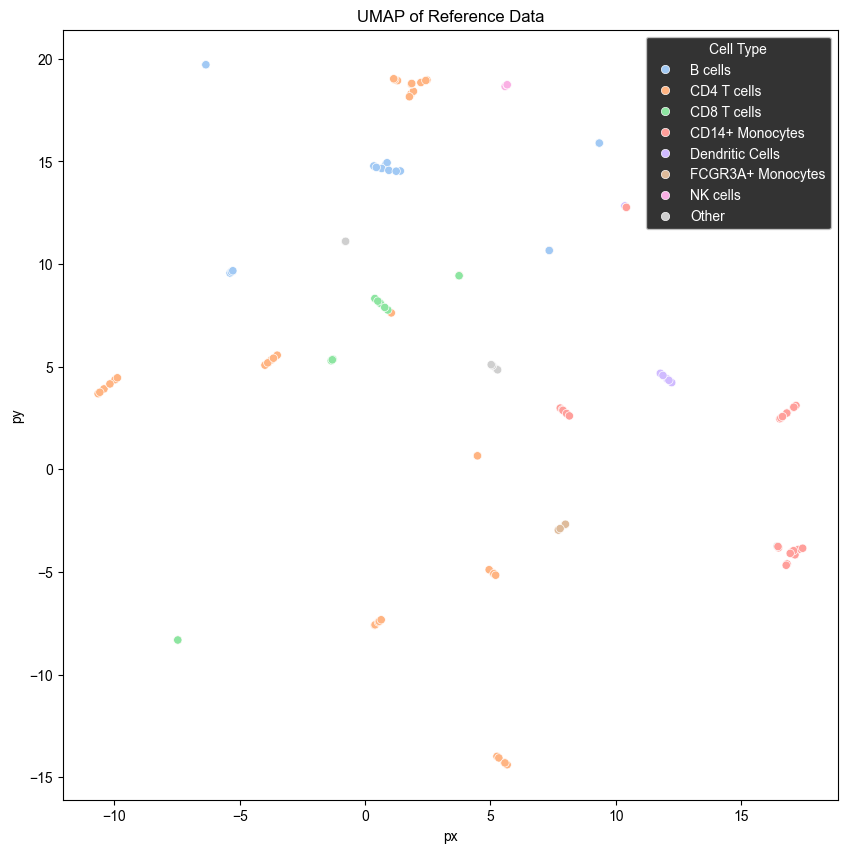

In [8]:
reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=2)
mapper = reducer.fit(ref_embeddings)

labels = X_train.obs['cell_type']

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")
plt.title('UMAP of Reference Data')
plt.show()

In [26]:
test_data = uce.process_data(X_test, data_config_path="./data/config.json")
test_embeddings = uce.get_embeddings(test_data)

2024-05-02, 11:08:10.869 helical.models.uce.gene_embeddings INFO Finished loading gene embeddings for {'human'} from data/uce/protein_embeddings
2024-05-02, 11:08:10.894 helical.models.uce.gene_embeddings INFO Filtered out 0 genes to a total of 12000 genes with embeddings.
2024-05-02, 11:08:11.517 helical.models.uce.uce_utils INFO Passed the gene expressions (with shape=(60, 12000) and max gene count data 344.0) to ./test_counts.npz
2024-05-02, 11:08:12.535 helical.models.uce.uce_utils INFO UCEDataset and DataLoader prepared. Setting batch_size=5 for inference.
2024-05-02, 11:08:12.536 UCE-Model INFO Inference started
100%|██████████| 12/12 [00:35<00:00,  2.92s/it]


In [27]:
labels = X_train.obs['cell_type']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

pred_labels = neigh.predict(test_embeddings)

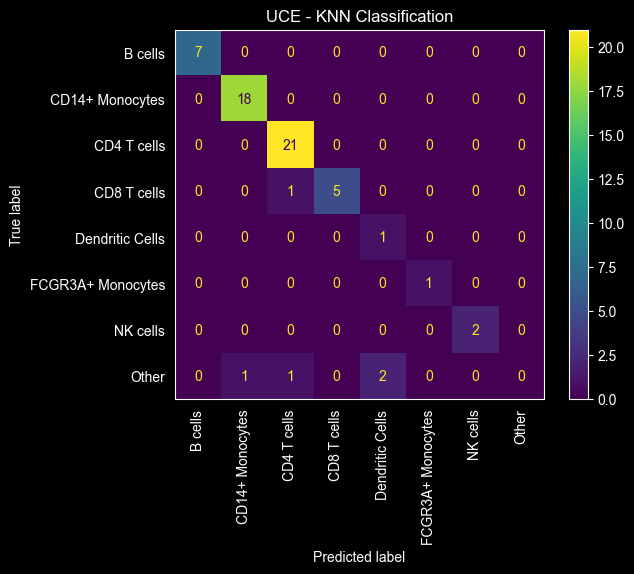

In [29]:
cm = confusion_matrix(X_test.obs['cell_type'],pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(xticks_rotation="vertical")
plt.title("UCE - KNN Classification")
plt.show()

In [30]:
print(classification_report(X_test.obs['cell_type'],pred_labels))

                   precision    recall  f1-score   support

          B cells       1.00      1.00      1.00         7
  CD14+ Monocytes       0.95      1.00      0.97        18
      CD4 T cells       0.91      1.00      0.95        21
      CD8 T cells       1.00      0.83      0.91         6
  Dendritic Cells       0.33      1.00      0.50         1
FCGR3A+ Monocytes       1.00      1.00      1.00         1
         NK cells       1.00      1.00      1.00         2
            Other       0.00      0.00      0.00         4

         accuracy                           0.92        60
        macro avg       0.77      0.85      0.79        60
     weighted avg       0.88      0.92      0.89        60



If you have any questions about this notebook, don't hesitate to reach out to us on Slack:
